In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Data and Main Variables

In [2]:
models = ["jinaai/jina-embeddings-v3",
          "jinaai/jina-embeddings-v4",
           "Snowflake/snowflake-arctic-embed-l-v2.0", "BAAI/bge-m3", 
           'sentence-transformers/all-MiniLM-L6-v2', 
           'sentence-transformers/all-mpnet-base-v2', 
           'Qwen/Qwen3-Embedding-0.6B', 'google/embeddinggemma-300m']

In [3]:
EMBEDDING_COLUMN = models[-1]
AGGREGATION_VARIABLE = "eu_party"
df = pd.read_parquet("data/speech_embeddings (1).parquet")
vocab_df = pd.read_parquet("data/vocab_embeddings (2).parquet")

In [4]:
text_data = pd.read_csv("data/migration_speeches_lda (2).csv", sep="\t")
text_data.head()

,Unnamed: 0.1,Unnamed: 0,speaker,text,party,date,agenda,speechnumber,procedure_ID,partyfacts_ID,...,topic_40,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49
0,332,573438,Jorge Salvador Hernández Mollar,"(ES) Madam President, we find ourselves, in th...",PPE-DE,1999-09-15,7. Preparation of the European Council meeting...,12,,6398.0,...,0.000106,0.000106,0.000106,0.352073,0.000106,0.000106,0.010367,0.013483,0.000106,0.119138
1,1237,572136,Alain Krivine,"(FR) Mr President, in spite of all the fine wo...",GUE/NGL,1999-10-27,1. Outcome of the European Council of 15/16 Oc...,28,,6402.0,...,0.000178,0.000178,0.000178,0.251157,0.011422,0.000178,0.000178,0.029150,0.000178,0.000178
2,2106,570825,Alain Krivine,"(FR) Mr President, the Eurodac project shows t...",GUE/NGL,1999-11-18,5. Eurodac,12,bill_8660_ID bill_8937_ID,6402.0,...,0.000194,0.000194,0.000194,0.296740,0.013165,0.000194,0.000194,0.000194,0.000194,0.000194
3,2107,570822,Anna Terrón i Cusí,"(ES) Mr President, I would like to ask you to ...",PSE,1999-11-18,5. Eurodac,9,bill_8660_ID bill_8937_ID,6399.0,...,0.000152,0.000152,0.000152,0.277078,0.000152,0.061388,0.000152,0.057551,0.000152,0.000152
4,2110,570819,Pernille Frahm,"(DA) Mr President, in our Group we view Euroda...",GUE/NGL,1999-11-18,5. Eurodac,6,bill_8660_ID bill_8937_ID,6402.0,...,0.038942,0.000095,0.000095,0.277556,0.000095,0.000095,0.000095,0.032221,0.000095,0.000095


In [5]:
df = df.merge(text_data, how='left', on=['date', 'speechnumber', 'agenda'])

In [6]:
df = df[df['topic_43'] > 0.35]

# Helper Functions

In [7]:
def get_aggregated_embeddings_for_year(df: pd.DataFrame, embedding_column: str, aggregate_on: str, year: int):
    year_subset = df[pd.to_datetime(df['date']).dt.year == year]
    aggregated_embeddings = year_subset.groupby(by=aggregate_on)[embedding_column].agg(lambda emb: np.stack(emb).mean(axis=0) )
    return aggregated_embeddings.reset_index()
get_aggregated_embeddings_for_year(df, embedding_column=EMBEDDING_COLUMN, aggregate_on=AGGREGATION_VARIABLE, year=2015)

,eu_party,google/embeddinggemma-300m
0,ALDE,"[-0.05895647, 0.06081142, -0.02473892, 0.02023..."
1,ECR,"[-0.05148361, 0.041459925, -0.02710367, 0.0117..."
2,EFDD,"[-0.05656942, 0.05216023, -0.02854623, 0.02017..."
3,ENF,"[-0.06239911, 0.04715605, -0.016974237, 0.0014..."
4,GUE/NGL,"[-0.059754744, 0.05173269, -0.030518517, 0.015..."
5,Greens/EFA,"[-0.061353955, 0.04689887, -0.027833765, 0.018..."
6,PPE,"[-0.05428557, 0.056458447, -0.031683665, 0.019..."
7,S&D,"[-0.060397696, 0.057682723, -0.030354837, 0.02..."


In [8]:
def get_aggregated_embeddings_for_each_year(df: pd.DataFrame, embedding_column: str, aggregate_on: str):
    yearly_data = df.copy()
    yearly_data['year'] = pd.to_datetime(df['date']).dt.year
    aggregated_embeddings = yearly_data.groupby(by=[aggregate_on, 'year'])[embedding_column].agg(lambda emb: np.stack(emb).mean(axis=0) )
    return aggregated_embeddings.reset_index()
get_aggregated_embeddings_for_each_year(df, embedding_column=EMBEDDING_COLUMN, aggregate_on=AGGREGATION_VARIABLE)

,eu_party,year,google/embeddinggemma-300m
0,ALDE,2005,"[-0.059848215, 0.009226808, -0.035455894, 0.02..."
1,ALDE,2006,"[-0.03941343, 0.015015518, -0.047109023, 0.016..."
2,ALDE,2007,"[-0.056003705, 0.047655903, -0.017093975, 0.01..."
3,ALDE,2008,"[-0.037719302, -0.013020473, -0.0036376943, -0..."
4,ALDE,2009,"[-0.047296073, 0.05044575, -0.021481762, 0.050..."
...,...,...,...
156,The Left,2021,"[-0.06945293, 0.029967248, -0.025811229, 0.007..."
157,The Left,2022,"[-0.061281536, 0.009742178, -0.013525555, 0.01..."
158,The Left,2023,"[-0.053241014, 0.028355807, -0.03017092, 0.036..."
159,UEN,2007,"[-0.063436694, -0.014817971, 0.009562911, -0.0..."


# Patterns over time

## PCA based shifts

In [9]:
df[EMBEDDING_COLUMN].iloc[0].shape

(768,)

In [10]:
from sklearn.decomposition import PCA


aggregate_on = "eu_party"
aggregated = get_aggregated_embeddings_for_each_year(df, EMBEDDING_COLUMN, aggregate_on)
pca = PCA(n_components=168)
reduced = pca.fit_transform(np.stack(aggregated[EMBEDDING_COLUMN]))
pca.explained_variance_.sum()

ValueError: n_components=168 must be between 0 and min(n_samples, n_features)=161 with svd_solver='full'

In [336]:
df[EMBEDDING_COLUMN].iloc[0]

array([ 0.06738281, -0.0123291 ,  0.08007812, ...,  0.03039551,
       -0.01855469, -0.0324707 ], shape=(1024,), dtype=float32)

In [347]:
pca.components_.shape

(168, 768)

In [348]:
pca.explained_variance_ 

array([1.54751474e-02, 1.02014914e-02, 8.96327198e-03, 7.20829889e-03,
       6.03012461e-03, 5.43636456e-03, 4.81179683e-03, 4.20682225e-03,
       3.79485311e-03, 3.68312886e-03, 3.61464126e-03, 3.28958500e-03,
       3.00385361e-03, 2.81265331e-03, 2.74059945e-03, 2.58169067e-03,
       2.55975407e-03, 2.31548818e-03, 2.14808993e-03, 2.04748171e-03,
       2.01325188e-03, 1.98192126e-03, 1.91489328e-03, 1.79090421e-03,
       1.66182744e-03, 1.58246257e-03, 1.50717166e-03, 1.44895120e-03,
       1.38982350e-03, 1.31434086e-03, 1.28556800e-03, 1.24707678e-03,
       1.21682184e-03, 1.12554873e-03, 1.06278190e-03, 1.05599104e-03,
       1.01583754e-03, 9.73368587e-04, 9.61993355e-04, 9.41130100e-04,
       9.13985481e-04, 8.89630464e-04, 8.62943649e-04, 8.60720407e-04,
       8.44009453e-04, 8.09455174e-04, 7.80557806e-04, 7.40574615e-04,
       7.16081238e-04, 7.09161512e-04, 6.66425854e-04, 6.55466167e-04,
       6.34309894e-04, 6.05525624e-04, 5.86643349e-04, 5.70174714e-04,
      

In [359]:
def closest_words_for_pc(k, eigen_vectors, vocab, probe_embs, top_n=20):
    pc_vec = eigen_vectors[k]
    pc_vec = pc_vec / np.linalg.norm(pc_vec)

    sims = probe_embs @ pc_vec   

    pos_idx = np.argsort(sims)[-top_n:]
    neg_idx = np.argsort(sims)[:top_n]

    print(f"\n=== PC{k+1} ===")
    print("Positive side:")
    for i in reversed(pos_idx):
        print(f"{vocab[i]:>25} | sim={sims[i]: .3f}")

    print("\nNegative side:")
    for i in neg_idx:
        print(f"{vocab[i]:>25} | sim={sims[i]: .3f}")

closest_words_for_pc(9, pca.components_, vocab_df['word'], np.stack(vocab_df[EMBEDDING_COLUMN]), top_n=10)

# unhcr UN refugee agency


=== PC10 ===
Positive side:
                   deaths | sim= 0.173
                 seawatch | sim= 0.165
                drownings | sim= 0.159
                   seabed | sim= 0.158
                 maritime | sim= 0.151
          spanishmoroccan | sim= 0.146
               fatalities | sim= 0.146
            decriminalise | sim= 0.144
                 canaries | sim= 0.143
                    drown | sim= 0.143

Negative side:
             turkishgreek | sim=-0.156
             turkeygreece | sim=-0.144
                    italy | sim=-0.140
              franceitaly | sim=-0.140
                   italys | sim=-0.138
                georgians | sim=-0.137
                relocated | sim=-0.137
                   grazzi | sim=-0.136
          turkishoccupied | sim=-0.133
              relocatable | sim=-0.131


In [354]:
closest_words_for_pc(1, pca.components_, vocab_df['word'], np.stack(vocab_df[EMBEDDING_COLUMN]), top_n=10)



=== PC2 ===
Positive side:
         humanitarianally | sim= 0.217
          humanitarianism | sim= 0.210
             humanitarian | sim= 0.202
                 humanely | sim= 0.196
               humanistic | sim= 0.177
              humanrights | sim= 0.176
            compassionate | sim= 0.175
                humanitys | sim= 0.171
                  refuges | sim= 0.168
               inhumanity | sim= 0.168

Negative side:
             immigrations | sim=-0.180
           illegitimately | sim=-0.169
                illegally | sim=-0.169
             quasiillegal | sim=-0.167
               immigrated | sim=-0.166
                  illegal | sim=-0.166
               immigrants | sim=-0.163
            infiltrations | sim=-0.162
                smuggling | sim=-0.160
             illegitimate | sim=-0.157


In [287]:
color_map = {
    # Social-democratic / centre-left
    "PSE": "#E41A1C",      # red – classic social-democrats
    "S&D": "#D62728",      # modern centre-left red

    # Green / regionalist
    "Greens/EFA": "#32CD32",   # bright ecological green

    # Liberal / centrist
    "ALDE": "#FFD700",     # gold – liberal-centrist
    "ELDR": "#FFC300",     # yellow – predecessor of ALDE
    "Renew": "#F2C400",    # Renew Europe → ALDE lineage; slightly softer gold

    # Conservative / Christian-democratic / centre-right
    "PPE": "#1F77B4",      # royal blue – centre-right
    "PPE-DE": "#1E90FF",   # lighter center-right
    "UEN": "#F4D03F",      # yellow-ish soft right/Christian-democratic

    # Right-wing Eurosceptic / conservative-nationalist
    "ECR": "#0057A4",      # deep conservative blue
    "IND/DEM": "#6A5ACD",  # purple – right-wing eurosceptic
    "EFD": "#7B68EE",      # medium purple – eurosceptic
    "EFDD": "#9370DB",     # softer purple – populist eurosceptic
    "EDD": "#8A2BE2",      # violet – early eurosceptic right

    # Far-right / nationalist
    "ITS": "#00008B",      # dark navy – far-right
    "ENF": "#000080",      # navy – nationalist far-right
    "ID": "#806000",       # earthy brown – Identity & Democracy

    # Left / far-left
    "The Left": "#8B0000", # deep dark red – consistent with GUE/NGL lineage
    "GUE/NGL": "#8B0000",  # far-left red
}



## Combined

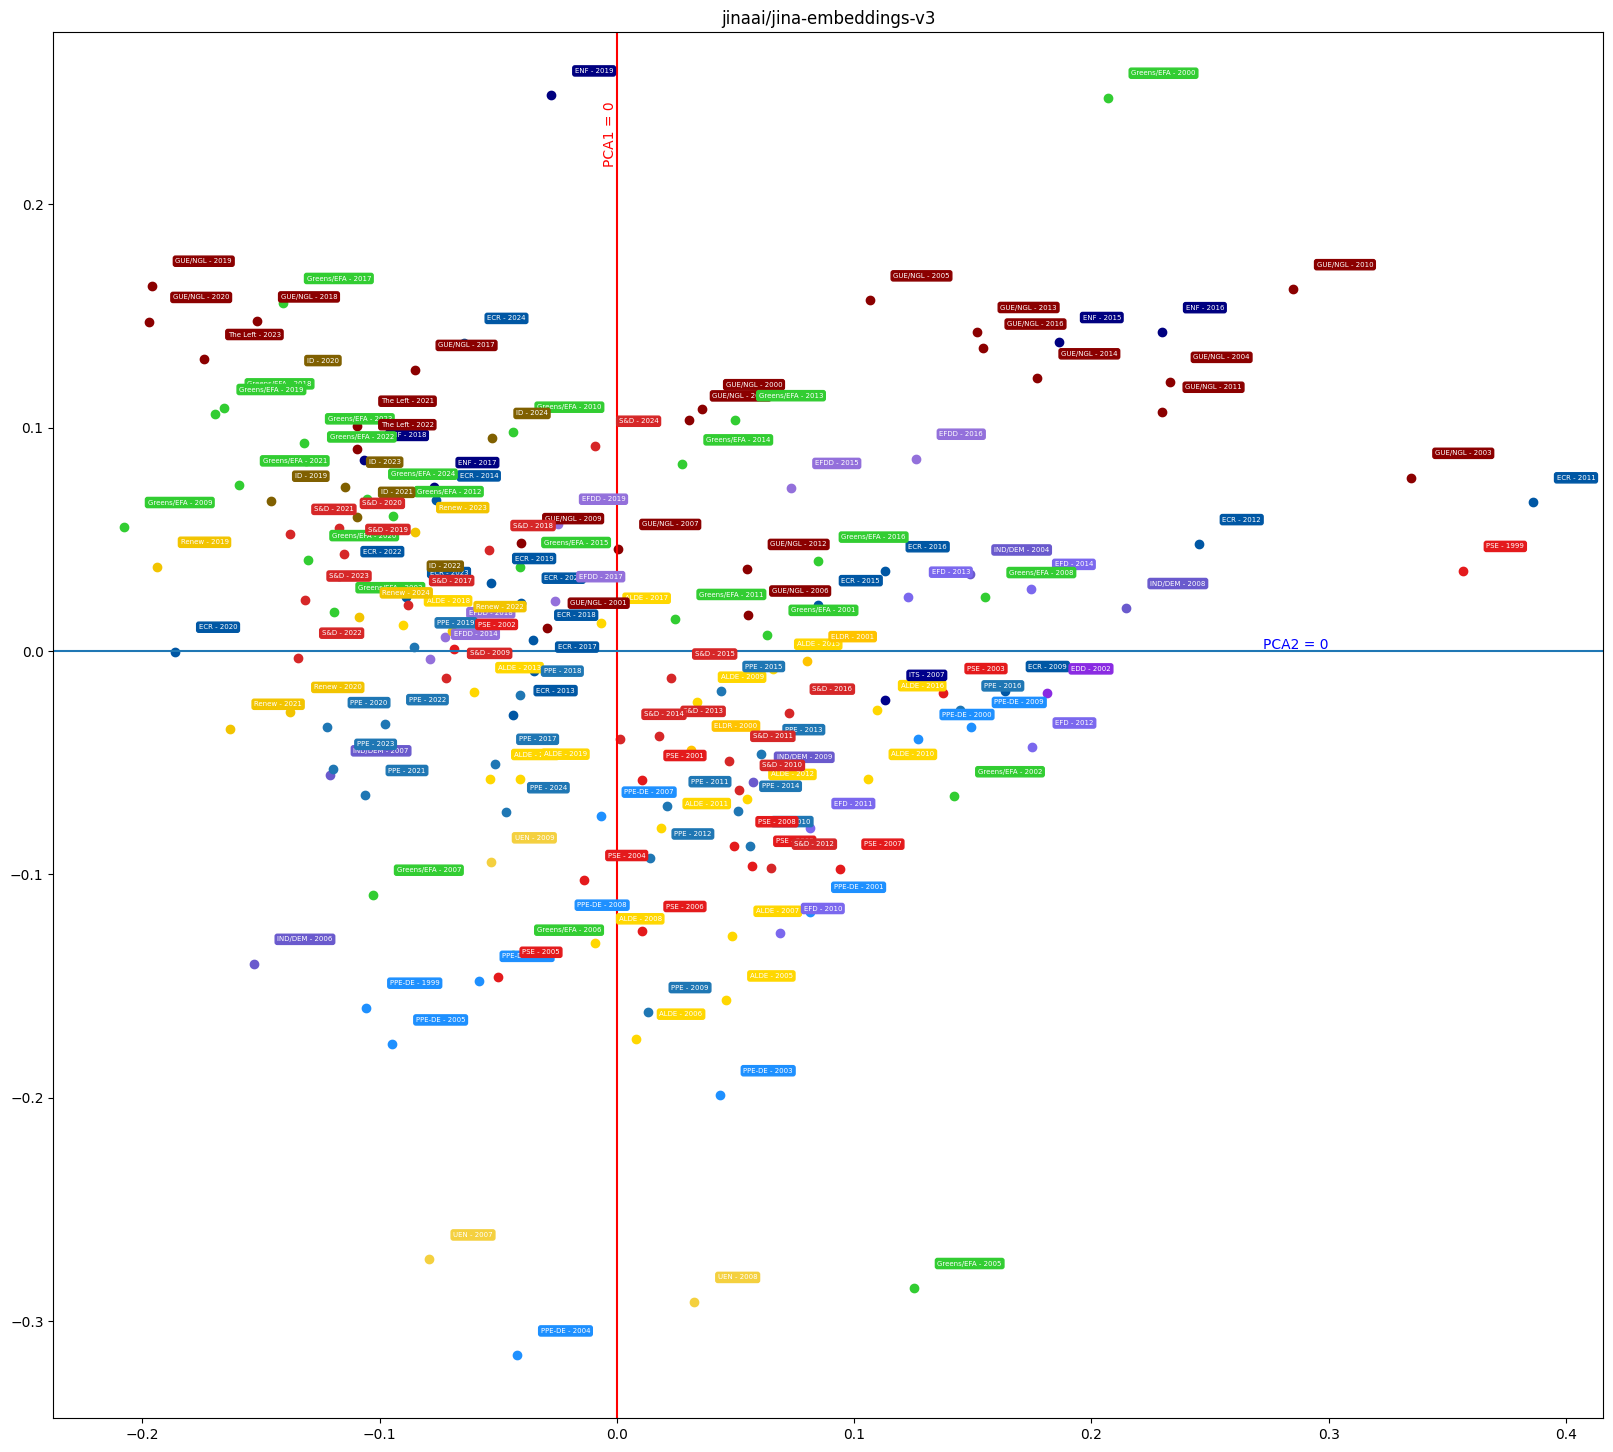

In [330]:
fig = plt.figure(figsize=(20, 18))
ax = fig.add_subplot()
plt.title(EMBEDDING_COLUMN)

plt.axvline(0, color='red', label="PCA1 == 0")
plt.axhline(0,  label="PCA2 == 0")
ax.text(0, 0.95, 'PCA1 = 0', color='r', ha='right', va='top', rotation=90,
            transform=ax.get_xaxis_transform())
ax.text(0.3, 0.006, 'PCA2 = 0', color='b', ha='right', va='top')
for party in aggregated[aggregate_on].unique():
    party_mask = aggregated[aggregate_on] == party
    years = aggregated[party_mask]['year']
    party_embeddings = reduced[party_mask]
    
    plt.scatter(party_embeddings[:, 0], party_embeddings[:, 1], marker='o', color=color_map[party])
    for i, year in enumerate(years):
      plt.text(party_embeddings[i,0]+0.01, party_embeddings[i,1]+0.01, f"{party} - {year}", fontsize=5, bbox=dict(boxstyle="round", color=color_map[party]), color='white')

## Individual

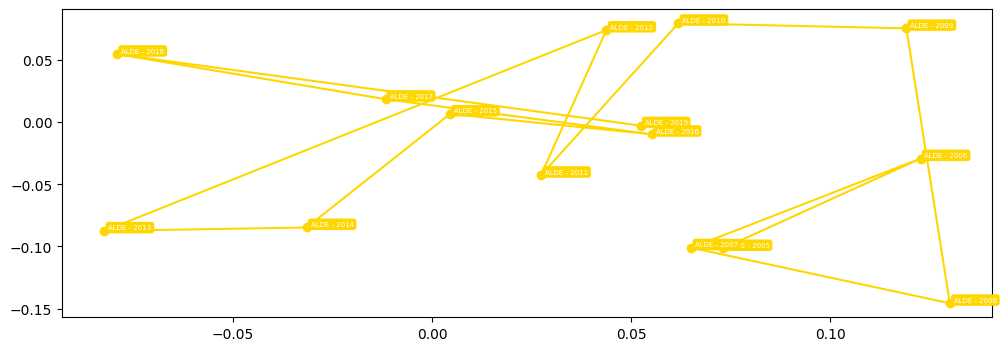

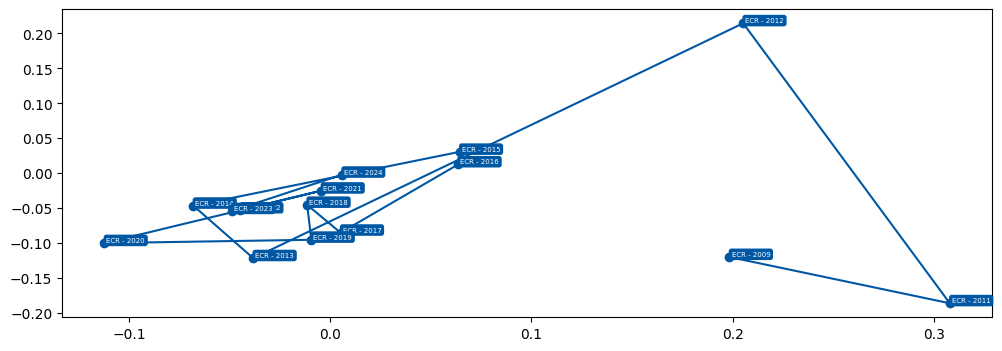

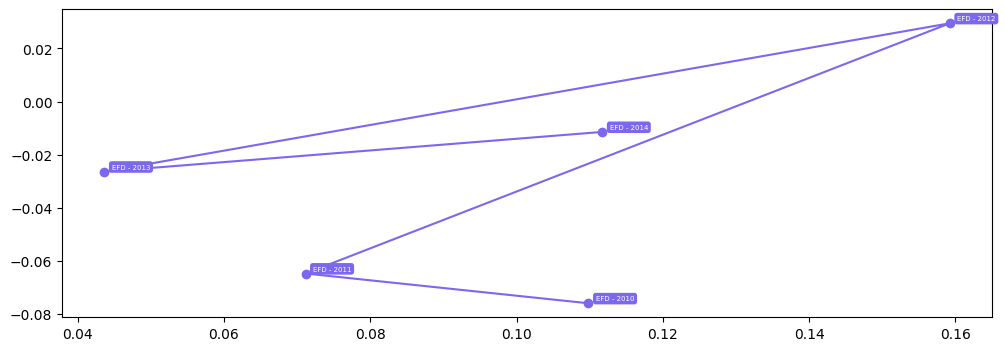

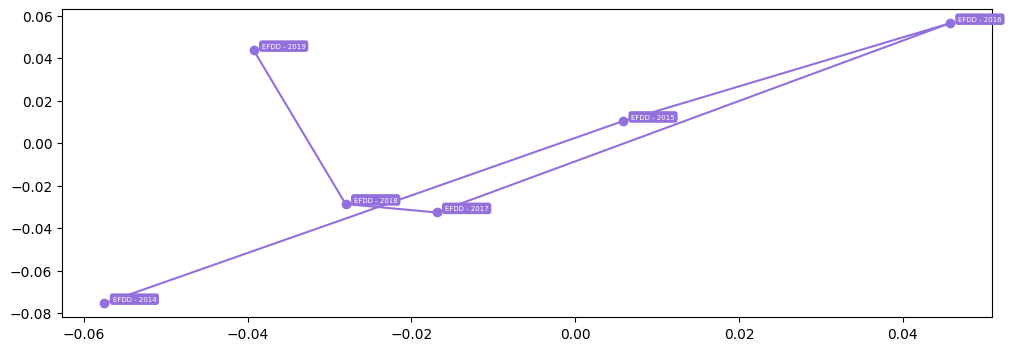

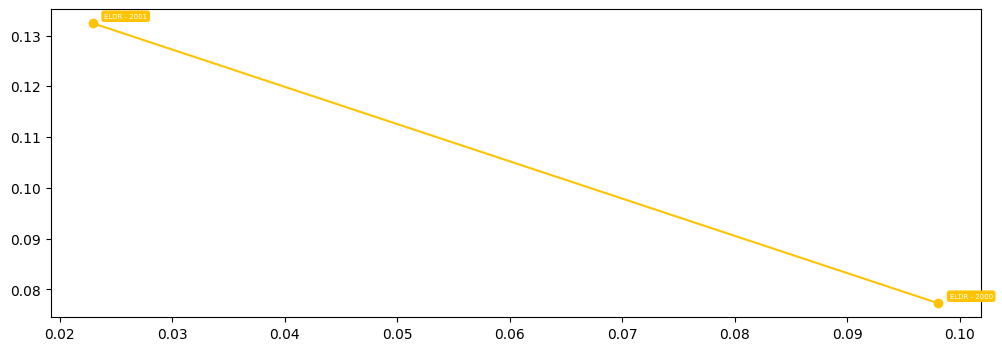

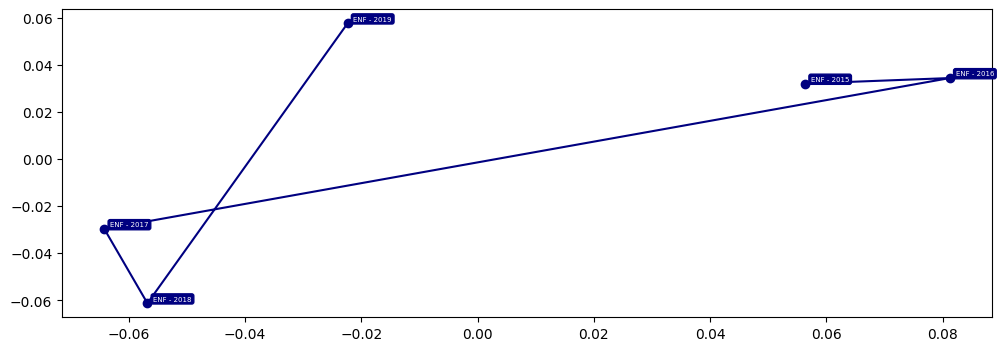

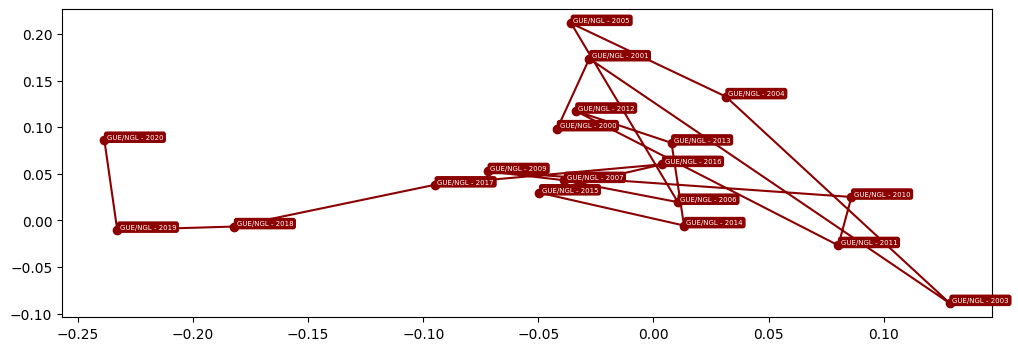

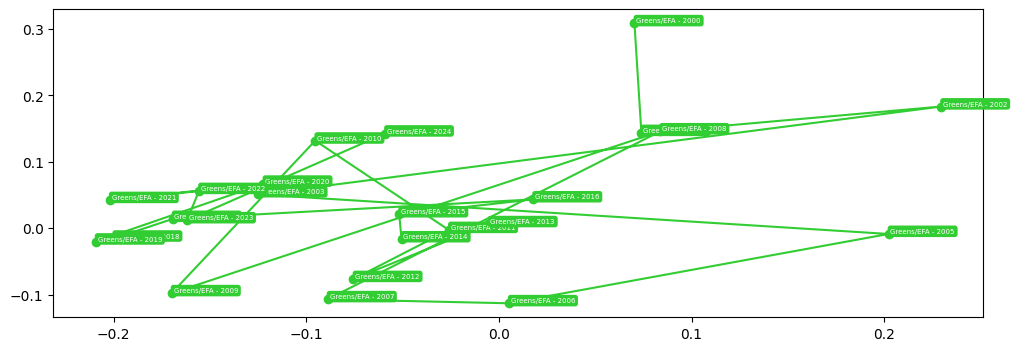

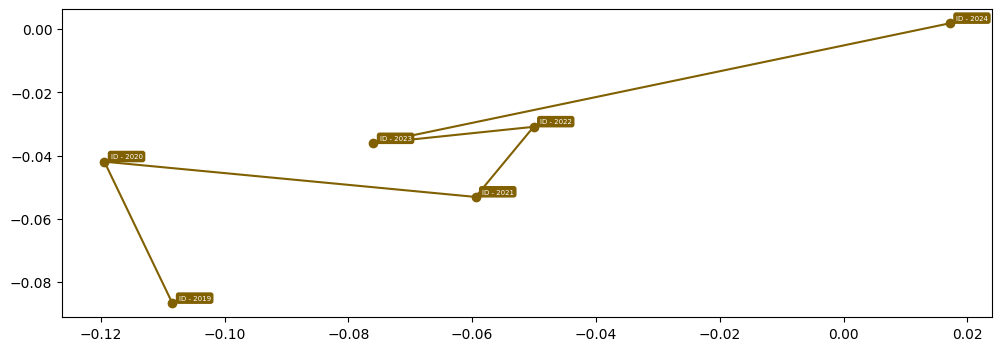

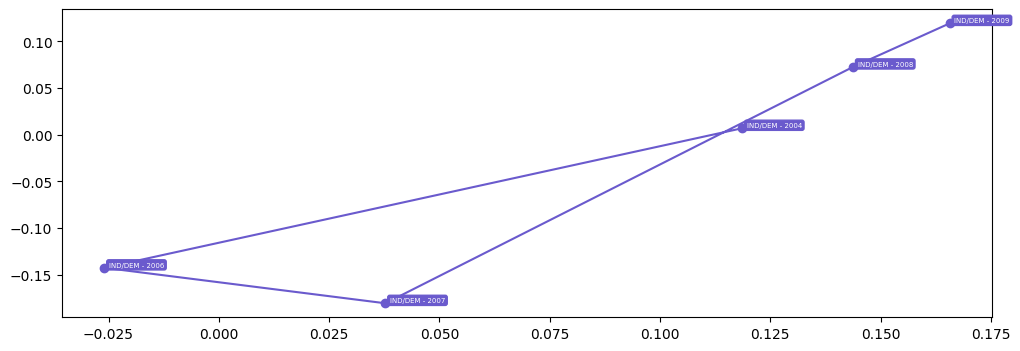

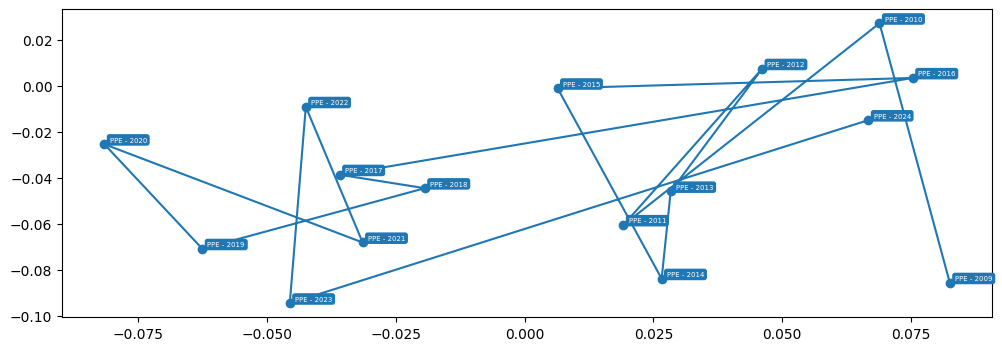

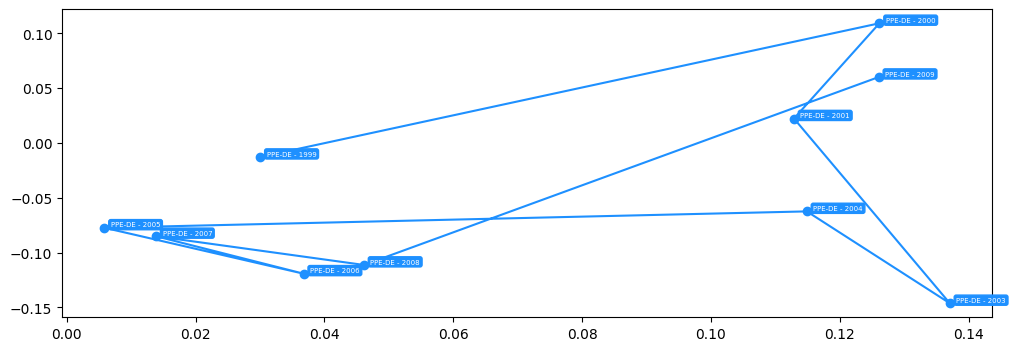

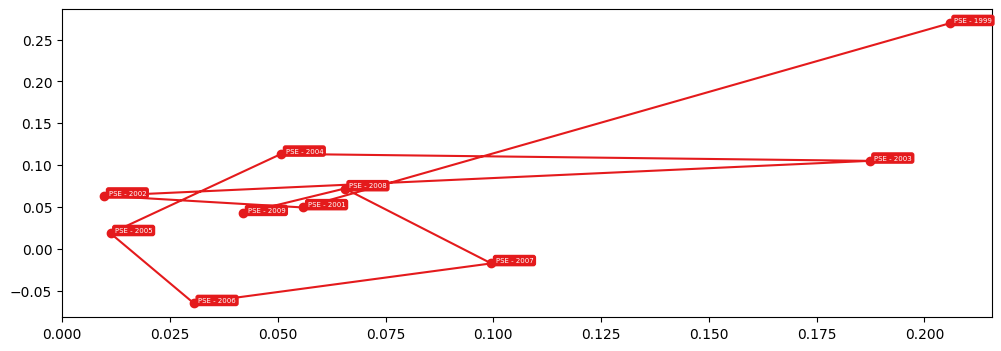

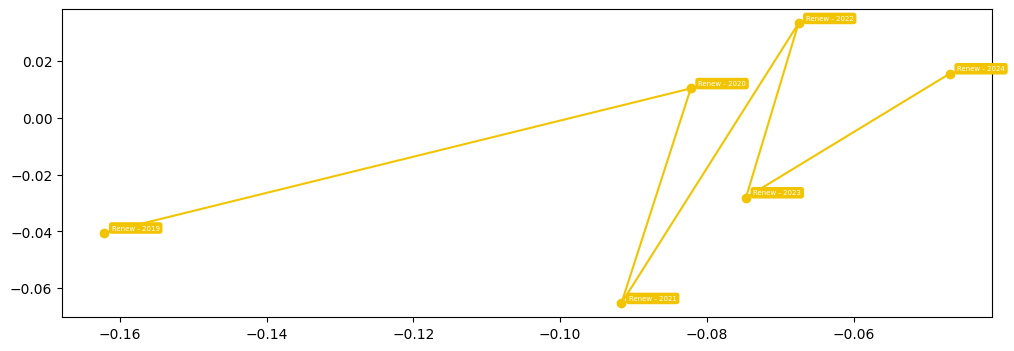

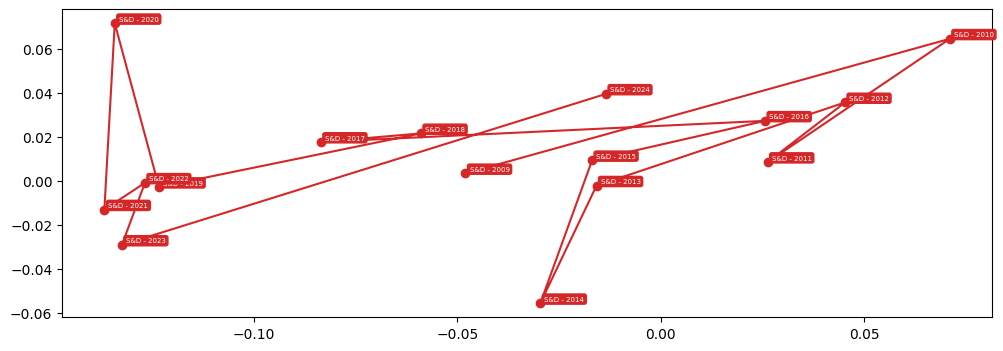

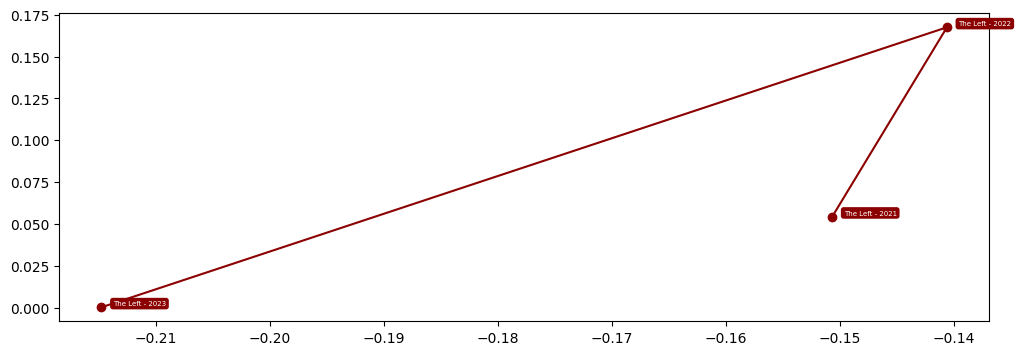

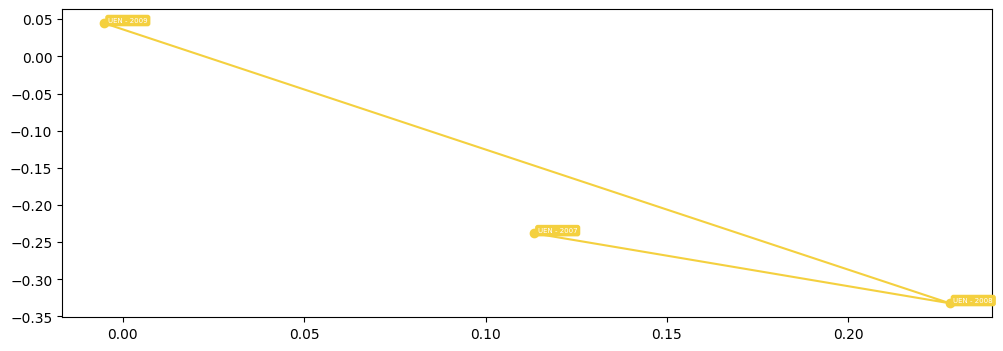

In [260]:
for party in aggregated[aggregate_on].unique():
    party_mask = aggregated[aggregate_on] == party
    years = aggregated[party_mask]['year']
    if len(years) < 2:
       continue
    fig, ax = plt.subplots(figsize=(12, 4))
    party_embeddings = reduced[party_mask]
    ax.plot(party_embeddings[:, 0], party_embeddings[:, 1], marker='o', color=color_map[party])
    for i, year in enumerate(years):
      ax.text(party_embeddings[i,0]+0.001, party_embeddings[i,1]+0.001, f"{party} - {year}", fontsize=5, bbox=dict(boxstyle="round", color=color_map[party]), color='white')


## Ideological Distance over the years

### Ideological Shift

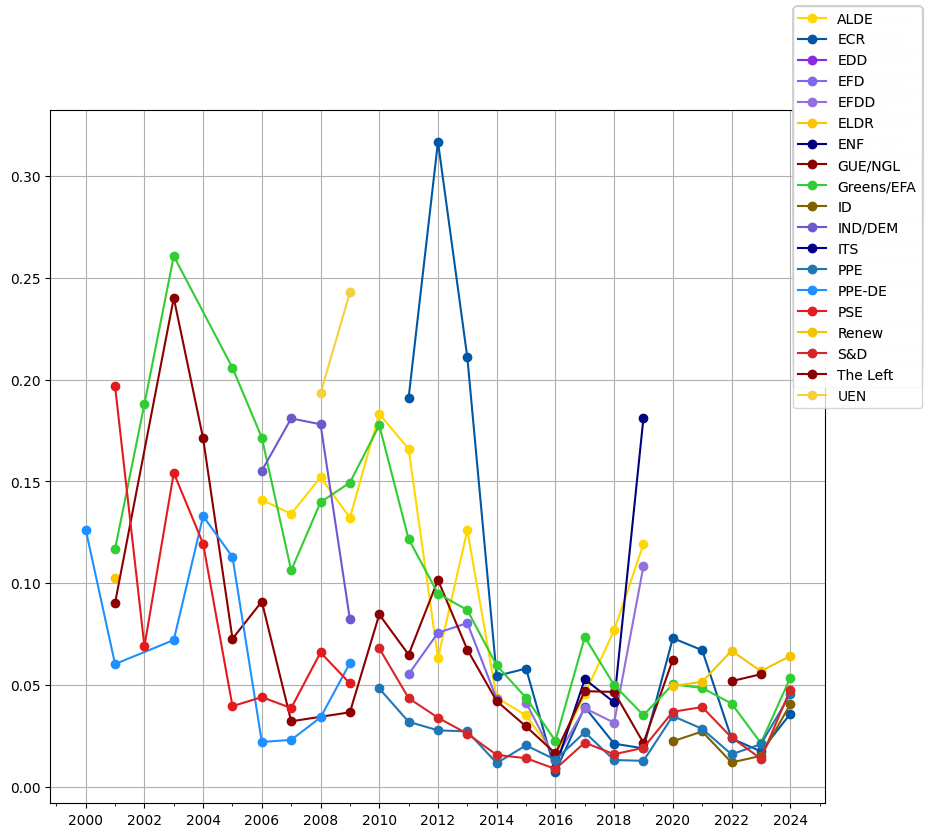

In [244]:
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot()
for party in aggregated[aggregate_on].unique():
    party_mask = aggregated[aggregate_on] == party
    years = aggregated[party_mask]['year']
    party_embeddings = np.stack(aggregated[EMBEDDING_COLUMN][party_mask])
    cos_sim = (party_embeddings[:-1] * party_embeddings[1: ]).sum(axis=1) / (np.linalg.norm(party_embeddings[:-1], axis=1) * np.linalg.norm(party_embeddings[1:], axis=1))
    cos_distance = 1 - cos_sim
    plt.plot(years[1:], cos_distance, marker='o',  label=party, color=color_map[party])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    fig.legend()
    ax.grid()
    


### Ideological Closeness

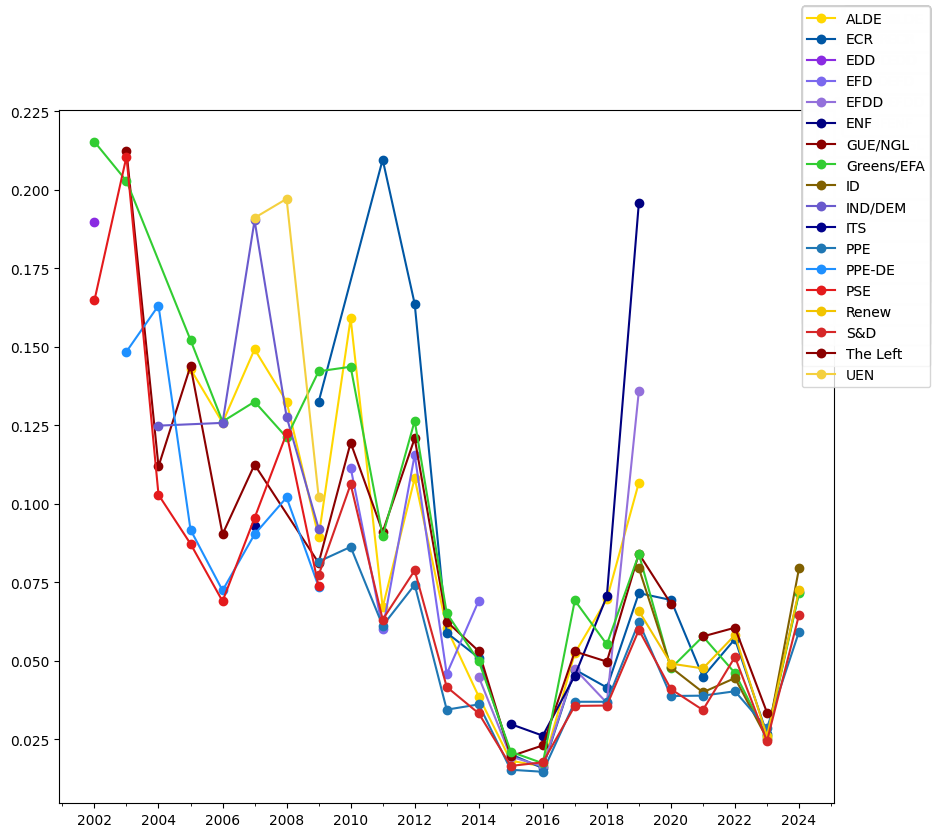

In [245]:
import matplotlib.ticker as ticker
from torch.nn.functional import cosine_similarity
import torch

fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot()
aggregated = aggregated[aggregated['year'] > 2001]
for party in aggregated[aggregate_on].unique():
    party_mask = aggregated[aggregate_on] == party
    years = aggregated[party_mask]['year']
    party_embeddings = np.stack(aggregated[EMBEDDING_COLUMN][party_mask])
    other_parties = aggregated[~party_mask]
    cos_distances = []
    for idx, year in enumerate(years):
        curr_party_embedding = party_embeddings[idx]
        other_party_embeddings = np.stack(other_parties[other_parties['year'] == year][EMBEDDING_COLUMN])
        cos_sim = cosine_similarity(torch.from_numpy(other_party_embeddings), torch.from_numpy(curr_party_embedding))
        cos_distance = 1 - cos_sim
        cos_distances.append(cos_distance.mean())

    plt.plot(years, cos_distances, marker='o',  label=party, color=color_map[party])
    ax.grid()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    fig.legend()
    